In [5]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy
from torch.optim import SGD
import matplotlib.pyplot as plt
import seaborn as sns
from pacmagic.visualizing.model_plots import plot_calibration_curve

In [6]:
class MCDropout(nn.Module):
    """Simple MLP with dropout option.

    Parameters
    ----------
    in_dim: int
        Number of features in
    n_classes: int
        Number of classes
    p: float
        Dropout probability.
    """

    def __init__(self,
                 in_dim: int,
                 n_classes: int,
                 hidden_dims: tuple = (32, 32),
                 p: float = 0.1,
                 class_weights: list = None):
        super(MCDropout, self).__init__()
        self.dropout_p: float = p

        self.architecture: list = [in_dim] + [dim for dim in hidden_dims] + [n_classes]

        self.layers: list = []

        # Add linear combinations to the forward function. So iterating up to the n-1th layer and
        # adding combinations up to the nth layer.
        for i in range(len(self.architecture) - 1):
            self.layers.append(nn.Linear(self.architecture[i], self.architecture[i + 1]))

            # Don't add these in the final linear combination.
            if i < len(self.architecture) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=self.dropout_p))

        self.f: nn.Sequential = nn.Sequential(*self.layers)
        self.n_classes: int = n_classes
        self.in_dim: int = in_dim
        self.n_samples = 512

        weight_tensor = None  # Placeholder
        if self.n_classes == 1:
            if class_weights is not None:
                weight_tensor = torch.Tensor([class_weights[1]])
            self.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

        else:
            if class_weights is not None:
                weight_tensor = torch.Tensor(class_weights)
            self.nll = nn.CrossEntropyLoss(weight=weight_tensor, reduction='sum')

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        """Pytorch forward funcion.

        Parameters
        ----------
        input_tensor: torch.Tensor
            input tensor.

        Returns
        -------
        output_tensor: torch.Tensor
            output tensor.
        """
        if len(input_tensor.shape) > 2:
            x: torch.Tensor = input_tensor.view(-1, self.in_dim)
        else:
            x = input_tensor
        output_tensor: torch.Tensor = self.f(x)
        return output_tensor


In [7]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [8]:
models = nn.ModuleList([MCDropout(X_train.shape[1], 1, (64,)) for _ in range(8)])

In [9]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

In [10]:
data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [12]:
# optimizer = SGD(model.parameters(), lr=5e-1, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(models.parameters(), lr=1e-2)

In [16]:
best_val_loss = np.inf
patience = 0

for epoch_idx in range(10000):
    
    models.train()
    outputs = [model(data) for model in models]
    loss = [models[i].nll(outputs[i], target) for i in range(len(outputs))]
    
    loss = sum(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch_idx % 10 == 0:
        
        models.eval()
        outputs_val = [model(data_val) for model in models]
        loss_val = [models[i].nll(outputs_val[i], target_val) for i in range(len(outputs))]
        loss_val = sum(loss_val)
        print(loss_val.item())
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
        else:
            patience += 1
            
            if patience == 8:
                break

16994.9375
12179.259765625
10544.6240234375
9768.263671875
9062.22265625
8612.802734375
8266.5087890625
7942.57275390625
7632.365234375
7363.83349609375
7156.1337890625
7006.09375
6901.013671875
6828.33642578125
6775.70166015625
6736.427734375
6705.943359375
6680.1533203125
6658.1845703125
6637.46142578125
6617.94140625
6600.2333984375
6583.28173828125
6565.08837890625
6548.46484375
6532.0654296875
6515.39599609375
6499.66845703125
6482.4775390625
6466.3359375
6449.71875
6432.80712890625
6416.84765625
6400.8740234375
6384.619140625
6369.71826171875
6353.15966796875
6337.5263671875
6322.2333984375
6306.49853515625
6289.44580078125
6274.1201171875
6256.9892578125
6241.318359375
6224.623046875
6208.75537109375
6193.6015625
6179.8798828125
6164.18701171875
6149.98388671875
6134.48583984375
6120.3310546875
6105.14306640625
6092.15478515625
6078.90869140625
6064.70556640625
6052.708984375
6040.841796875
6029.966796875
6017.27685546875
6007.48583984375
5996.10693359375
5985.1650390625
5974.69

In [17]:
with torch.no_grad():
    models.train()
    outputs = torch.sigmoid(torch.stack([models[i](data_val) for i in range(len(models))for _ in range(64)])).squeeze(-1)

In [19]:
probs = outputs.mean(0).numpy()
stds = outputs.std(0).numpy()

In [20]:
cutoff = np.percentile(probs, 100 * (1-y_train.values.mean()))

preds = probs > cutoff

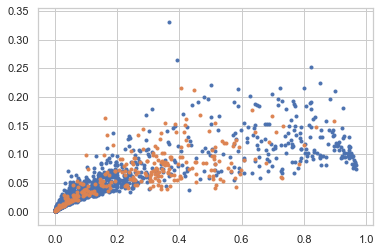

In [21]:
plt.scatter(probs[preds == y_test.squeeze().values], stds[preds == y_test.squeeze().values], marker='.')
plt.scatter(probs[preds != y_test.squeeze().values], stds[preds != y_test.squeeze().values], marker='.')

In [22]:
y_true = y_test.squeeze().values

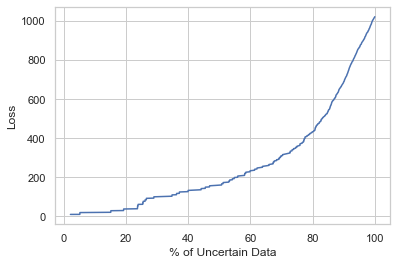

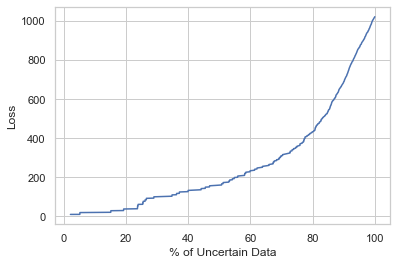

In [23]:
make_performance_uncertainty_plot(y_true, probs, stds, 'Loss', performance_fn_args={'reduction': 'sum'})

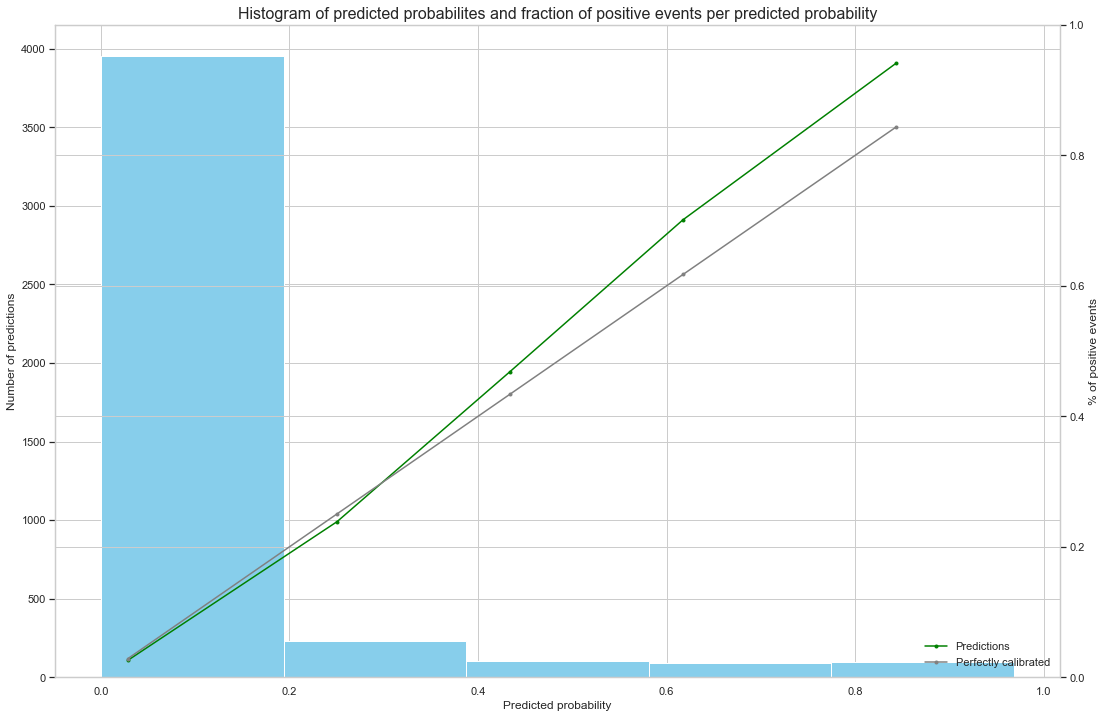

In [24]:
plot_calibration_curve(y_true, probs)

In [67]:
# loss at 100%
cross_entropy(y_true, probs, reduction='sum')

1023.4894186058082

In [68]:
# loss at 50%

y_50 = y_true[stds.argsort()[:int(0.5 * len(stds))]]
y_prob_50 = probs[stds.argsort()[:int(0.5 * len(stds))]]

cross_entropy(y_50, y_prob_50, reduction='sum')

160.0619855914265

In [97]:
conf_intervals = np.clip(np.array([probs - 5 * stds,
           probs - 4 * stds,
           probs - 3 * stds,
           probs - 2 * stds,
           probs - 1 * stds,
           probs - 0 * stds,
           probs + 1 * stds,
           probs + 2 * stds,
           probs + 3 * stds,
           probs + 4 * stds,
           probs + 5 * stds]), 0, 1).T

In [123]:
pred_intervals = np.array([probs - 5 * stds,
           probs - 4 * stds,
           probs - 3 * stds,
           probs - 2 * stds,
           probs - 1 * stds,
           probs - 0 * stds,
           probs + 1 * stds,
           probs + 2 * stds,
           probs + 3 * stds,
           probs + 4 * stds,
           probs + 5 * stds]) > cutoff
pred_intervals = pred_intervals.T.astype(int)

In [124]:
(pred_intervals[:, 0:11] == np.repeat(y_true[:, None], 11, axis=1)).any(axis=1).mean()

0.9816841635023453

In [125]:
conf_intervals[:, 0].mean(), conf_intervals[:, 10].mean()

(0.011278678, 0.17960562)

In [126]:
(pred_intervals[:, 1:10] == np.repeat(y_true[:, None], 9, axis=1)).any(axis=1).mean()

0.9785570694661604

In [127]:
conf_intervals[:, 1].mean(), conf_intervals[:, 9].mean()

(0.01754354, 0.16337594)

In [128]:
(pred_intervals[:, 2:9] == np.repeat(y_true[:, None], 7, axis=1)).any(axis=1).mean()

0.9740897922716104

In [129]:
conf_intervals[:, 2].mean(), conf_intervals[:, 8].mean()

(0.026988378, 0.14621815)

In [130]:
(pred_intervals[:, 3:8] == np.repeat(y_true[:, None], 5, axis=1)).any(axis=1).mean()

0.9673888764797856

In [131]:
conf_intervals[:, 3].mean(), conf_intervals[:, 7].mean()

(0.041973505, 0.12783447)

In [132]:
(pred_intervals[:, 4:7] == np.repeat(y_true[:, None], 3, axis=1)).any(axis=1).mean()

0.9582309582309583

In [133]:
conf_intervals[:, 4].mean(), conf_intervals[:, 6].mean()

(0.06277596, 0.107613884)

In [134]:
(pred_intervals[:, 5:6] == np.repeat(y_true[:, None], 1, axis=1)).any(axis=1).mean()

0.9385749385749386

In [135]:
conf_intervals[:, 5].mean(), conf_intervals[:, 5].mean()

(0.08543231, 0.08543231)